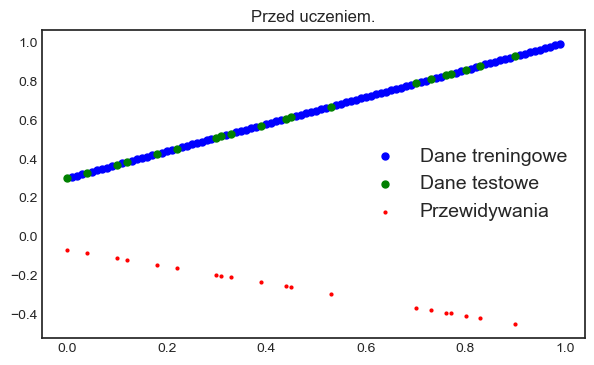

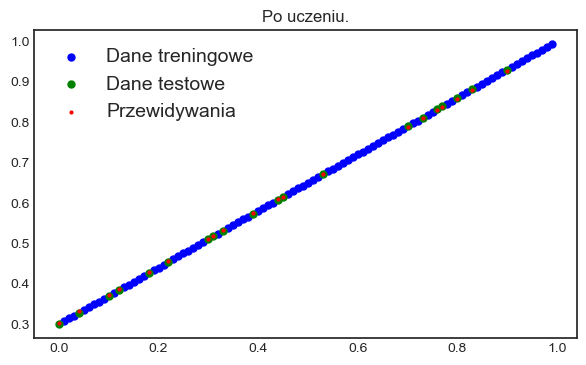

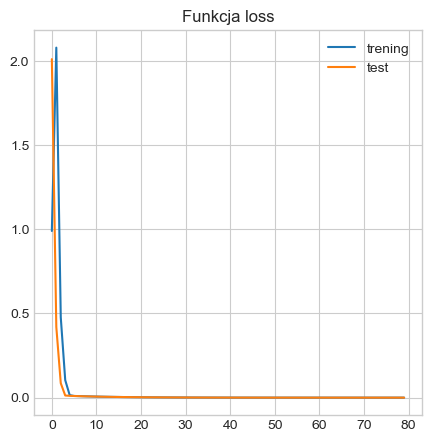

In [3]:
# CELE 
# Maszyna na podstawie danych ma się nauczyć wzorca rysowania lini (w równaniu y=ax+b odgadnąć a i b)

# ---------------------------------------------------------------------------------------------
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from helper_functions import plot_predictions, plot_decision_boundary, accuracy_fn, set_seeds, plot_loss_curves

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

# ---------------------------------------------------------------------------------------------
# przygotowanie danych
a = 0.7 
b = 0.3
X = torch.arange(start=0, end=1, step=0.01).unsqueeze(dim=1) # unsqueeze potrzebne do nn, dodanie dodatkowego wymiaru
y = a * X + b

# ---------------------------------------------------------------------------------------------
# rozdzielenie danych na treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------------------------------------------------------------------------
# przesłanie danych z cpu do gpu
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test  = y_test.to(device)

# ---------------------------------------------------------------------------------------------
# klasa modelu
# class ModelNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
#         self.layer_1 = nn.Linear(in_features=1, out_features=32) 
#         self.layer_2 = nn.Linear(in_features=32, out_features=32) 
#         self.layer_3 = nn.Linear(in_features=32, out_features=1) 
#     def forward(self, x):
#         return self.layer_3(self.layer_2(self.layer_1(x)))
# # instancja modelu
# set_seeds(42)
# model = ModelNN().to(device)

# klasa i model
class ModelNN(nn.Module):
    def __init__(self, input_features=1, output_features=1, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(),
            # nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)
# instancja modelu
set_seeds(42)
model = ModelNN(input_features=1, output_features=1, hidden_units=32).to(device)

# ---------------------------------------------------------------------------------------------
# pierwsze przedstawoenie danych, przed uczeniem
with torch.inference_mode(): 
    y_pred = model(X_test)
plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=y_pred, title='Przed uczeniem.') 

# ---------------------------------------------------------------------------------------------
# funkcja loss i ustawienie optymilizatora
# loss_fn = nn.L1Loss()
loss_fn = nn.MSELoss() # na tej działa szybciej i lepiej
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1) 

# ---------------------------------------------------------------------------------------------
epochs = 80
epoch_count = []
train_loss_values = []
test_loss_values = []

# pętla treningowa i danych testowych
for epoch in range(epochs):
    epoch_count.append(epoch)
    
    model.train() # Ustawienie modułu w trybie treningowym.
    y_pred = model(X_train) # tu się uruchamia funkcja forward
    loss = loss_fn(y_pred, y_train) # obliczenie różnic
    optimizer.zero_grad() # optymalizacja parametrów, Resetuje gradienty wszystkich zoptymalizowanych :class:`torch.Tensor`s.
    loss.backward() # backpropagation, Oblicza gradient tensora aktualnego względem elementów grafu.
    optimizer.step() # Wykonuje pojedynczy krok optymalizacji.
    train_loss_values.append(loss.cpu().detach().numpy())
    
    model.eval() 
    with torch.inference_mode(): 
        y_pred = model(X_test)
        loss = loss_fn(y_pred, y_test) # obliczenie różnic
        test_loss_values.append(loss.cpu().detach().numpy())
    
plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=y_pred, title='Po uczeniu.')     

plot_loss_curves({"train_loss": train_loss_values, "train_acc": None, "test_loss": test_loss_values, "test_acc": None})